# Libraries

In [25]:
# Data 
import pandas as pd
import numpy as np
import pyarrow
import pandas as pd
import missingno as msno
from sklearn.preprocessing import LabelEncoder

# Modelling
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import average_precision_score, classification_report,  roc_auc_score, accuracy_score

## SHAP plot
import shap
import matplotlib.pyplot as plt

# Admin
import pickle
import gc


# Data

In [26]:
data = pd.read_parquet('ed_single.parquet')

Select columns for model

In [27]:
cols_keep = [ 
    'gender', 
    'age',
    'race',
    'arrival_transport',
    'pain',
    'temperature',
    'heartrate',
    'resprate',
    'o2sat',
    'sbp',
    'dbp',
    'intime',
    'revisit_72hrs',
    'med_gsn_count',
    'prior_visits_1yr',
    'acuity',
    'cci_score', 
    'cluster', 
    'res',
    'nyu', 
    'disposition'
    ]
data = data[cols_keep].copy()

Make the CCI into as category with fewer levels

In [28]:
data['CCI_cat'] = np.where(data['cci_score'] >= 5, '6', data['cci_score'].astype(str))
data = data.drop(columns=['cci_score'])

Recode the number of visits in the last 12 months into a category

In [29]:
data['previous_cat'] = np.where(data['prior_visits_1yr'] >= 1, 1, 0)
data = data.drop(columns=['prior_visits_1yr'])

Create a time category

In [30]:
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

data['time_of_day'] = data['intime'].dt.hour.apply(categorize_time)
data = data.drop(columns=['intime'])

Create the outcome admitted 

In [31]:
data['home'] = data['disposition'].apply(lambda x: 1 if x == 'HOME' else 0)
data = data.drop(columns=['disposition'])

Ensure categpries are categories

In [32]:
data['nyu'] = data['nyu'].astype('int64')
data['res'] = data['res'].astype('int64')

columns_cat = ['gender', 'arrival_transport', 'revisit_72hrs','CCI_cat','previous_cat', 'cluster','time_of_day', 'nyu', 'res' , 'home' ]    
for col in columns_cat:      
    data[col] = data[col].astype('category')

## Missing

print missing data total

In [33]:
print(data.drop(columns=['nyu', 'res','home']).isna().sum())

gender                   0
age                      0
race                     0
arrival_transport        0
pain                 10349
temperature           9873
heartrate             6374
resprate              8123
o2sat                 8090
sbp                   6944
dbp                   7452
revisit_72hrs            0
med_gsn_count        71372
acuity                   0
cluster                  0
CCI_cat                  0
previous_cat             0
time_of_day              0
dtype: int64


<Axes: >

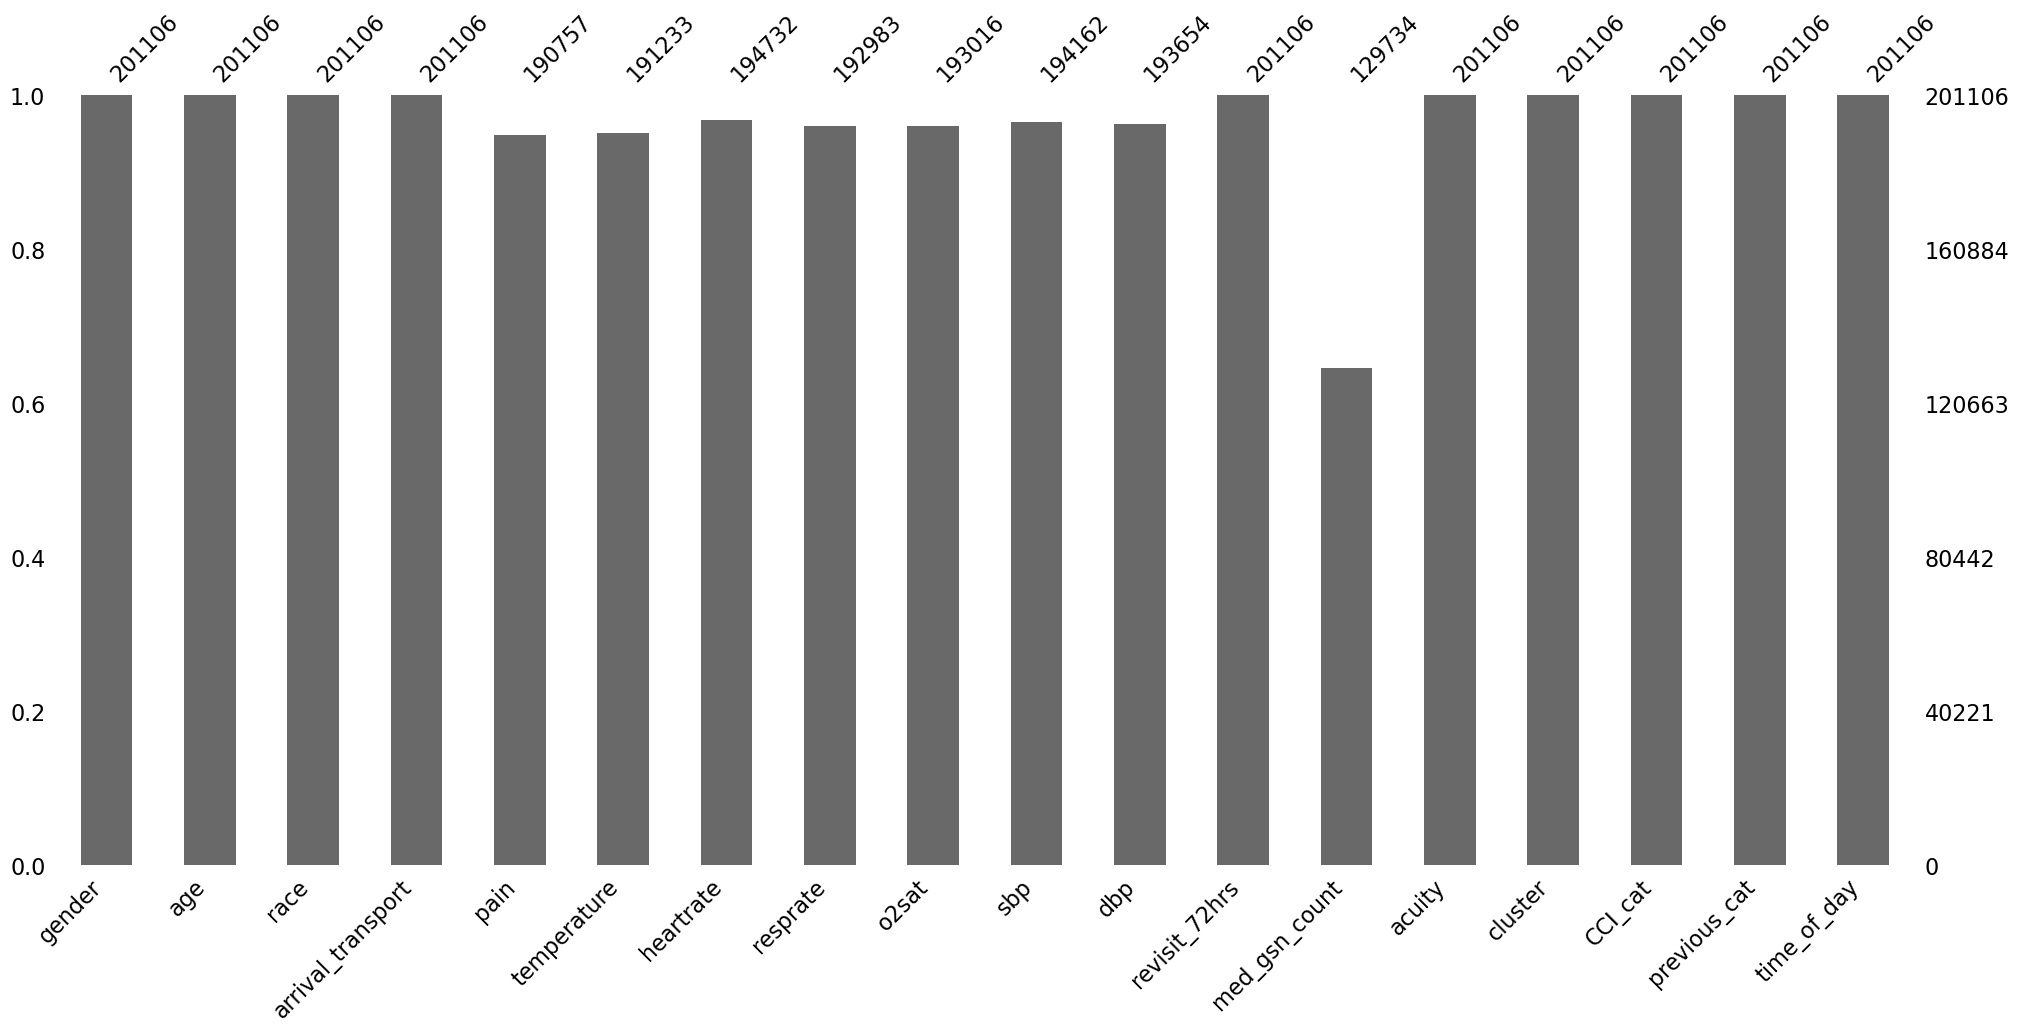

In [34]:
msno.bar(data.drop(columns=['nyu', 'res', 'home']))

<Axes: >

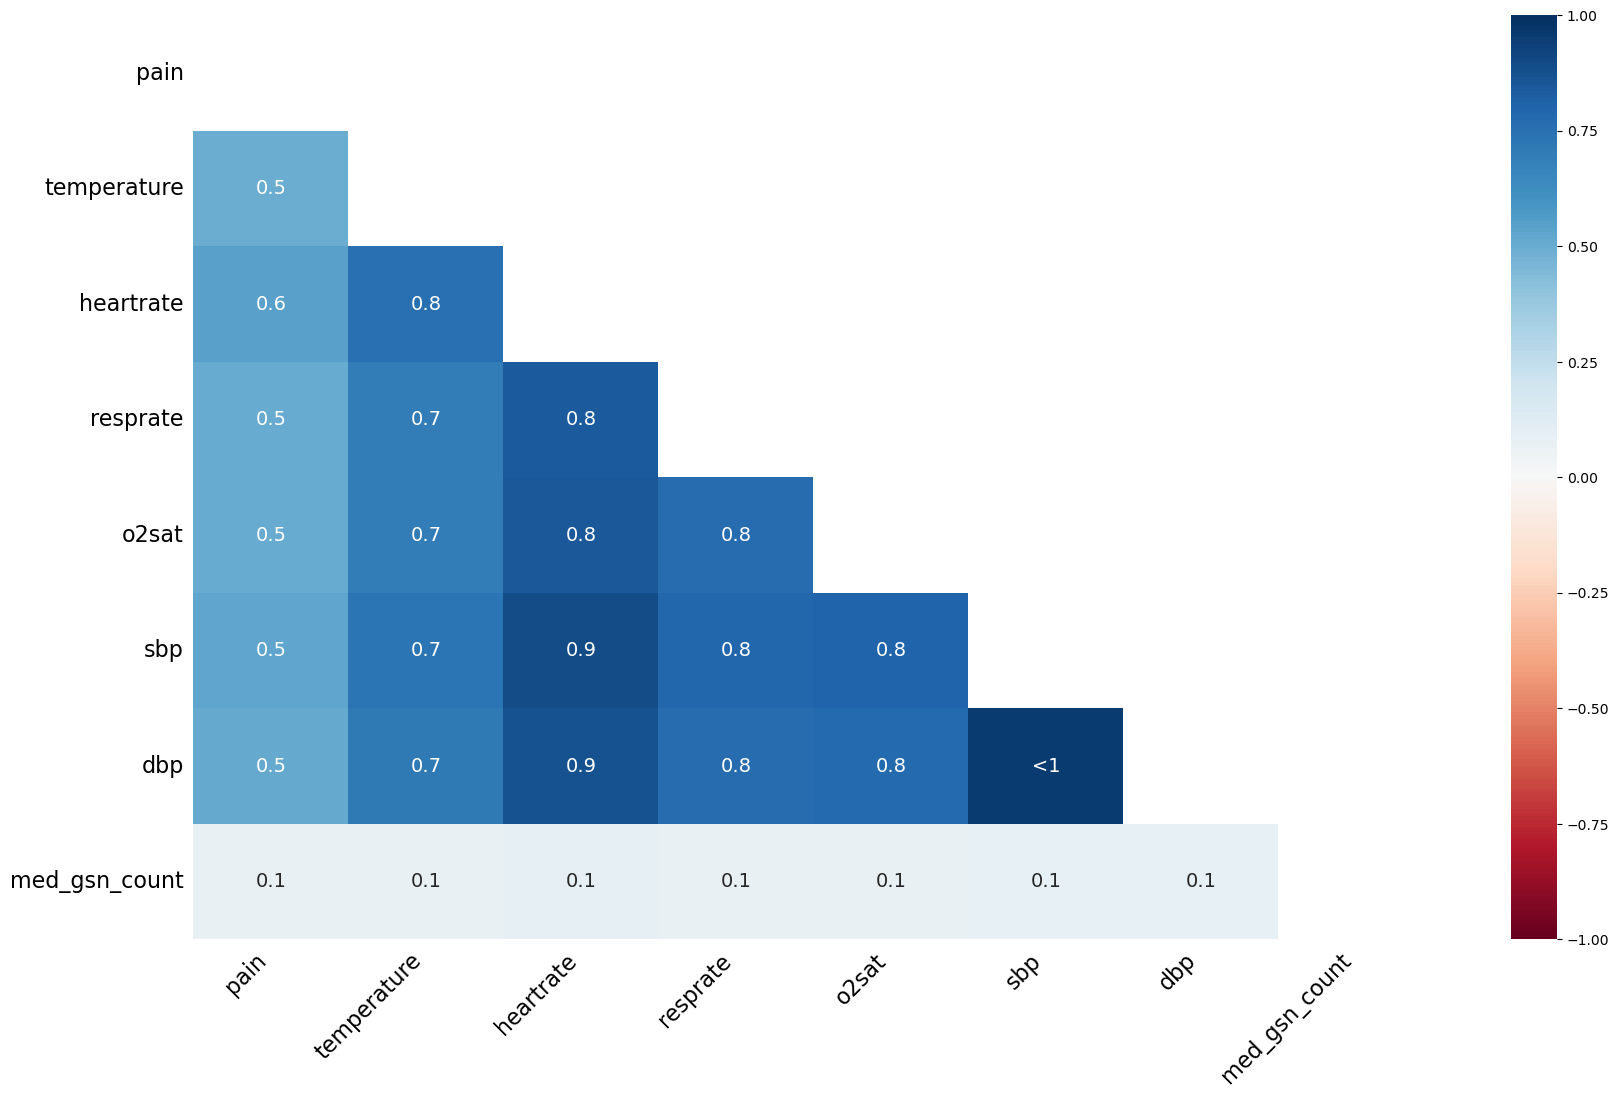

In [35]:
msno.heatmap(data.drop(columns=['nyu', 'res', 'home']))

Create an imputed dataset

For meds count, NA = 0

In [36]:
data['med_gsn_count'] = data['med_gsn_count'].fillna(0)

For the rest, median impute

In [37]:
m_cols = ['pain', 'age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
data_impute = data.copy()
data_impute[m_cols] = imputer.fit_transform(data[m_cols])

<Axes: >

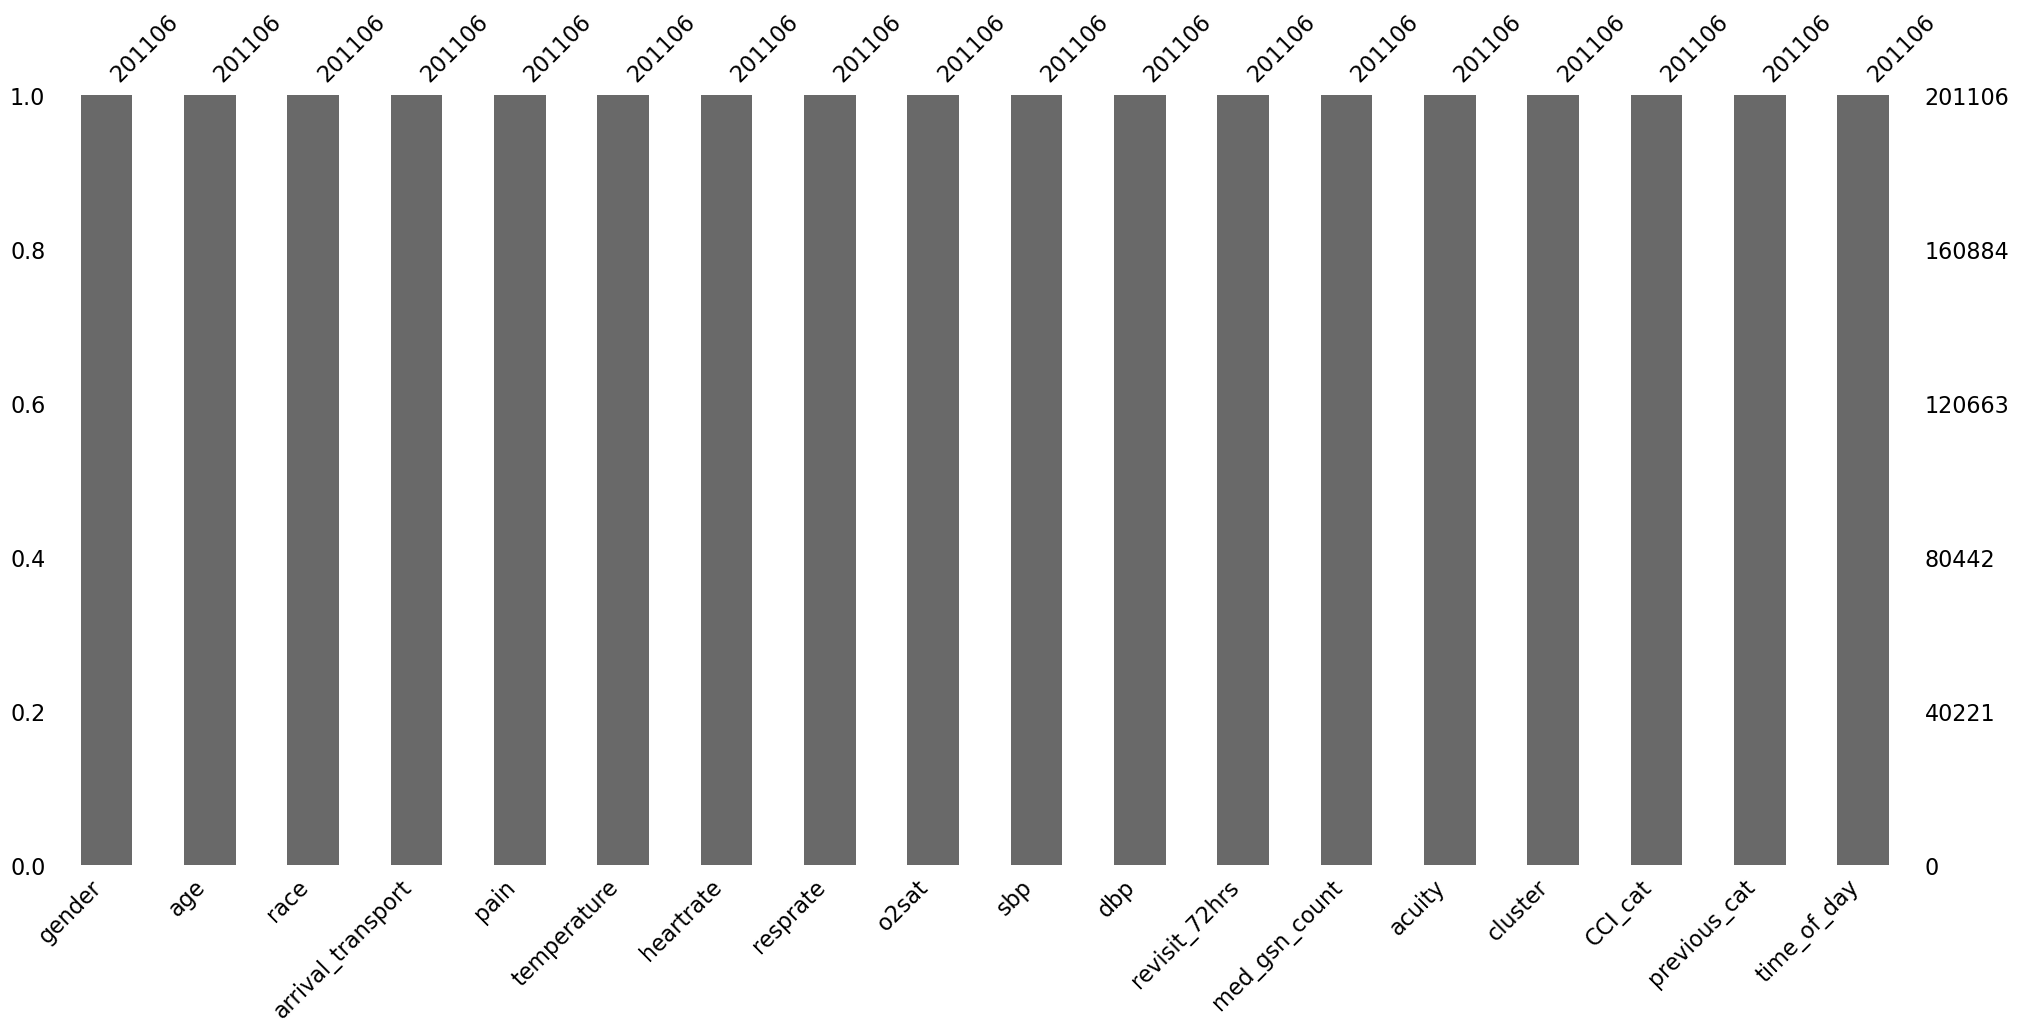

In [38]:
msno.bar(data_impute.drop(columns=['nyu', 'res',  'home']))

# Prediction

## Functions

In [39]:
# Format data
def data_process(df_in, predictors, target_columns, drop_first_in=False, tab = 'not_tab'):

   # Select relevant columns
    data_predict = df_in[predictors + target_columns].copy()
    
    # Identify column types
    numerical_cols = data_predict[predictors].select_dtypes(include='number').columns.tolist()
    categorical_cols = data_predict[predictors].select_dtypes(include=['object', 'category']).columns.tolist()

    if tab == 'tab':
        cat_idxs = []
        cat_dims = []
        for i, col in enumerate(categorical_cols):
            le = LabelEncoder()
            data_predict[col] = le.fit_transform(data_predict[col])
            cat_idxs.append(data_predict.columns.get_loc(col))
            cat_dims.append(data_predict[col].nunique())

    # Train-test split
    train_df, test_df = train_test_split(
        data_predict, 
        test_size=0.2, 
        random_state=42, 
        stratify=data_predict[target_columns]
    )
    
    # Separate X and y
    X_train = train_df[predictors].copy()
    X_test = test_df[predictors].copy()
    y_train = train_df[target_columns].copy()
    y_test = test_df[target_columns].copy()

    if tab == 'not_tab':
        # One-hot encode categorical columns
        X_train = pd.get_dummies(
        X_train,
        columns=categorical_cols,
        drop_first=drop_first_in
        )
        X_test = pd.get_dummies(
        X_test,
        columns=categorical_cols,
        drop_first=drop_first_in
        )

    # Align columns
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Sanity checks
    print('Train X shape:', X_train.shape)
    print("Test X shape:", X_test.shape)

    print(f"\nCheck proportions of outcome in data:")
    for col in y_train.columns:
        print(f"--- {col} ---")
        print("y_train proportions:")
        print(y_train[col].value_counts(normalize=True).sort_index())
        print("y_test proportions:")
        print(y_test[col].value_counts(normalize=True).sort_index())

    # Return fully separated objects
    return X_train, X_test, y_train, y_test

In [61]:
# XGBoost 
def xgb_f(X_train, y_train, X_test, y_test,rename_map, outcome):
    # Get original names for SHAP
    original_names = X_train.columns.tolist()

    # Calculate scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Model
    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        random_state=42,
        scale_pos_weight=scale_pos_weight[outcome]
    )
    # Fit
    model = clf.fit(X_train, y_train[outcome])
    # Predict
    y_pred = model.predict(X_test)
    # Probability for class 1
    y_proba = model.predict_proba(X_test)[:, 1]
    # Calculate AUC-PR
    pr_auc = average_precision_score(y_test, y_proba)
    print(f'PR AUC: {pr_auc:.2f}')
    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    print(f'AUC: {auc:.2f}')
    # Print report
    print(classification_report(y_test, y_pred, digits=2))

    # SHAP
    X_train_df = pd.DataFrame(X_train, columns=original_names)
    X_train_renamed = X_train_df.rename(columns=rename_map)

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_train_renamed)
    shap.summary_plot(
        shap_values, 
        X_train_renamed, 
        max_display=5,
        show=False
    )
    
    # Get figure
    fig = plt.gcf()
    ax = plt.gca()
    fig.text(
        x=0.01,             # X position in figure coordinates (0 = left, 1 = right)
        y=0.95,             # Y position in figure coordinates (0 = bottom, 1 = top)
        s=outcome,            # The title text
        fontsize=14,
        color='black',
        ha='left',          # Horizontal alignment
        va='top'            # Vertical alignment
    )

    # Set font color to black
    for text in ax.texts:
        text.set_color('black')

    # Save plot
    fig.savefig(f"{outcome}.svg", format="svg")
    plt.show()


    return {
        'model': model,
        'shap_values': shap_values,
    }

In [70]:
# ElasticNet
def elasticnet(X_train, y_train, X_test, y_test, outcome):
    original_names = X_train.columns.tolist()

    # scale numeric columns
    num_cols = X_train.select_dtypes(include='number').columns.tolist()
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

    # define and fit the model
    model = LogisticRegressionCV(
        cv = 5,
        penalty='elasticnet',
        l1_ratios=[0.1,0.5,0.9],
        solver='saga',
        max_iter=10000,
        random_state=42
    )
    model.fit(X_train_scaled, y_train[outcome])

    # predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # evaluate
    pr_auc = average_precision_score(y_test, y_proba)
    print(f'PR AUC: {pr_auc:.2f}')
    auc = roc_auc_score(y_test, y_proba)
    print(f'AUC: {auc:.2f}')
    print(classification_report(y_test, y_pred > 0.5, digits=2))

In [71]:
# TabNet
def tabnet(X_train, y_train, X_test, y_test, outcome):

    # make into np arrays
    X_train_np = X_train.to_numpy(dtype=np.float32)
    X_test_np = X_test.to_numpy(dtype=np.float32)
    y_train_np = y_train.to_numpy()
    y_train_np = y_train_np.ravel()
    y_test_np = y_test.to_numpy()
    y_test_np = y_test_np.ravel()

    # define the model
    model = TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=3,
        gamma=1.5,
        n_independent=2,
        n_shared=2,
        momentum=0.3,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.001),
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=42,
        verbose=0
    )

    # fit the model
    model.fit(
        X_train=X_train_np, y_train=y_train_np,
        eval_set=[(X_test_np, y_test_np)], 
        eval_name=['val'],
        eval_metric=['auc'], 
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # predict
    y_pred = model.predict(X_test_np)

    # probability for class 1
    y_proba = model.predict_proba(X_test_np)[:, 1]

    # calculate AUC-PR
    pr_auc = average_precision_score(y_test, y_proba)
    print(f'PR AUC: {pr_auc:.2f}')
    auc = roc_auc_score(y_test, y_proba)
    print(f'AUC: {auc:.2f}')

    # print report
    print(classification_report(y_test, y_pred > 0.5, digits=2))

    return {
        'model': model
    }


In [43]:
# Predictors list
predictors = [
    'gender', 
    'age',
    'race',
    'arrival_transport',
    'pain',
    'temperature',
    'heartrate',    
    'resprate',
    'o2sat',
    'sbp',
    'dbp',
    'time_of_day',
    'revisit_72hrs',
    'med_gsn_count',
    'previous_cat', 
    'acuity', 
    'cluster',
    'CCI_cat'
    ]


In [72]:
# SHAP variables list
rename_map = {
    'CCI_cat_0.0':'Charlson Comorbidity Index:0*',
    'CCI_cat_1.0':'Charlson Comorbidity Index:1*',
    'CCI_cat_2.0':'Charlson Comorbidity Index:2*',
    'CCI_cat_3.0':'Charlson Comorbidity Index:3*',
    'age': 'Age (years)',
    'gender_M': 'Gender: Male*',
    'gender_F': 'Gender: Female*',
    'pain': 'Pain Score (/10)',
    'race_WHITE': 'Race:White*',
    'arrival_transport_ambulance': 'Arrival: Ambulance*',
    'arrival_transport_walk in': 'Arrival: Walk In*',
    'cluster_1': 'Influenza like illness*',
    'cluster_2': 'Altered Mental Status +\nVehicle Collision*',
    'cluster_3': 'Chest pain +\nDyspnea*',
    'cluster_5': 'Abdominal Pain*',
    'cluster_7': 'Wound evaluation or \nAbnormal labs*',
    'cluster_10': 'Suicidal ideation*',
    'cluster_11': 'Fall*',
    'dbp': 'Diastolic BP (mmhg)',
    'sbp': 'Systolic BP (mmhg)',
    'o2sat': 'Oxygen Saturation (%)',
    'heartrate': 'Heart Rate (bpm)',
    'resprate': 'Respiratory Rate (bpm)',
    'temperature': 'Temperature (F)',
    'med_gsn_count': 'Number of Medications (N)',
    'acuity': 'Acuity (/5)',
    }

## Home

### Data

In [64]:
target_columns = ['home']

# XGBoost and Elastic net need different one hot encoding strategies
X_train_adxg, X_test_adxg, y_train_adxg, y_test_adxg = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=False,
    tab = 'not_tab'
)

X_train_ad, X_test_ad, y_train_ad, y_test_ad = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=True,
    tab = 'not_tab'
)

X_train_adtab, X_test_adtab, y_train_adtab, y_test_adtab = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=False,
    tab = 'tab'
)

Train X shape: (160884, 76)
Test X shape: (40222, 76)

Check proportions of outcome in data:
--- home ---
y_train proportions:
home
0    0.396304
1    0.603696
Name: proportion, dtype: float64
y_test proportions:
home
0    0.396301
1    0.603699
Name: proportion, dtype: float64
Train X shape: (160884, 68)
Test X shape: (40222, 68)

Check proportions of outcome in data:
--- home ---
y_train proportions:
home
0    0.396304
1    0.603696
Name: proportion, dtype: float64
y_test proportions:
home
0    0.396301
1    0.603699
Name: proportion, dtype: float64
Train X shape: (160884, 18)
Test X shape: (40222, 18)

Check proportions of outcome in data:
--- home ---
y_train proportions:
home
0    0.396304
1    0.603696
Name: proportion, dtype: float64
y_test proportions:
home
0    0.396301
1    0.603699
Name: proportion, dtype: float64


### XGBoost

PR AUC: 0.91
AUC: 0.88
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     15940
           1       0.85      0.84      0.84     24282

    accuracy                           0.81     40222
   macro avg       0.80      0.80      0.80     40222
weighted avg       0.81      0.81      0.81     40222



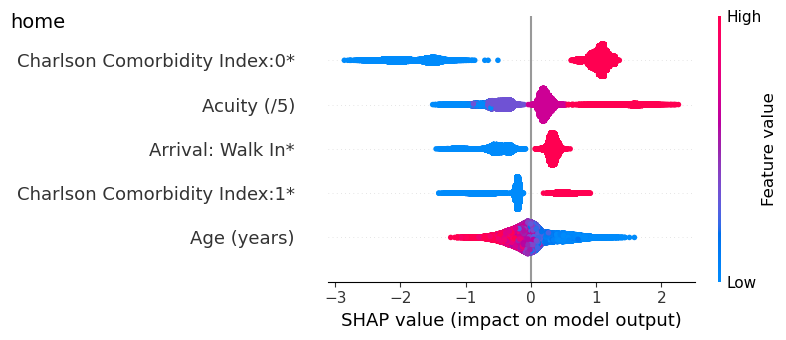

15834

In [65]:
ad_xgb = xgb_f(X_train_adxg,  y_train_adxg,X_test_adxg, y_test_adxg, rename_map, 'home')

with open('ad_xg.pkl', 'wb') as f:
    pickle.dump(ad_xgb, f)

del ad_xgb
gc.collect()

### Elastic net

In [73]:
ad_el = elasticnet(X_train_ad, y_train_ad, X_test_ad, y_test_ad, 'home')

with open('ad_el.pkl', 'wb') as f:
    pickle.dump(ad_el, f)

del ad_el
gc.collect()

PR AUC: 0.90
AUC: 0.88
              precision    recall  f1-score   support

           0       0.81      0.68      0.74     15940
           1       0.81      0.90      0.85     24282

    accuracy                           0.81     40222
   macro avg       0.81      0.79      0.80     40222
weighted avg       0.81      0.81      0.81     40222



11850

### Tabnet

In [76]:
ad_tabnet = tabnet(X_train_adtab, y_train_adtab, X_test_adtab, y_test_adtab, 'admitted')

with open('ad_tabnet.pkl', 'wb') as f:
    pickle.dump(ad_tabnet, f)

del ad_tabnet
gc.collect()


Early stopping occurred at epoch 90 with best_epoch = 70 and best_val_auc = 0.87861


/opt/anaconda3/envs/avoid_predict/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


PR AUC: 0.90
AUC: 0.88
              precision    recall  f1-score   support

           0       0.82      0.68      0.74     15940
           1       0.81      0.90      0.85     24282

    accuracy                           0.81     40222
   macro avg       0.81      0.79      0.80     40222
weighted avg       0.81      0.81      0.81     40222



2671

In [77]:
admitted_data = {
    'X_train_adxg': X_train_adxg,
    'X_test_adxg': X_test_adxg,
    'y_train_adxg': y_train_adxg,
    'y_test_adxg': y_test_adxg,
    'X_train_ad': X_train_ad,
    'X_test_ad': X_test_ad,
    'y_train_ad': y_train_ad,
    'y_test_ad': y_test_ad,
    'X_train_adtab': X_train_adtab,
    'X_test_adtab': X_test_adtab,
    'y_train_adtab': y_train_adtab,
    'y_test_adtab': y_test_adtab
}

with open('admitted_data.pkl', 'wb') as f:
    pickle.dump(admitted_data, f)
    
del X_train_adxg, X_test_adxg, y_train_adxg, y_test_adxg
del X_train_ad, X_test_ad, y_train_ad, y_test_ad
del X_train_adtab, X_test_adtab, y_train_adtab, y_test_adtab

## Diagnosis

### Data

In [62]:
target_columns = ['nyu']

# XGBoost and Elastic net need different one hot encoding strategies
X_train_diagxg, X_test_diagxg, y_train_diagxg, y_test_diagxg = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=False,
    tab = 'not_tab'
)

X_train_diag, X_test_diag, y_train_diag, y_test_diag = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=True,
    tab = 'not_tab'
)

X_train_diagtab, X_test_diagtab, y_train_diagtab, y_test_diagtab = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=False,
    tab = 'tab'
)

Train X shape: (160884, 76)
Test X shape: (40222, 76)

Check proportions of outcome in data:
--- nyu ---
y_train proportions:
nyu
0    0.669917
1    0.330083
Name: proportion, dtype: float64
y_test proportions:
nyu
0    0.669907
1    0.330093
Name: proportion, dtype: float64
Train X shape: (160884, 68)
Test X shape: (40222, 68)

Check proportions of outcome in data:
--- nyu ---
y_train proportions:
nyu
0    0.669917
1    0.330083
Name: proportion, dtype: float64
y_test proportions:
nyu
0    0.669907
1    0.330093
Name: proportion, dtype: float64
Train X shape: (160884, 18)
Test X shape: (40222, 18)

Check proportions of outcome in data:
--- nyu ---
y_train proportions:
nyu
0    0.669917
1    0.330083
Name: proportion, dtype: float64
y_test proportions:
nyu
0    0.669907
1    0.330093
Name: proportion, dtype: float64


### XGBoost

PR AUC: 0.63
AUC: 0.79
              precision    recall  f1-score   support

           0       0.84      0.70      0.76     26945
           1       0.54      0.73      0.62     13277

    accuracy                           0.71     40222
   macro avg       0.69      0.71      0.69     40222
weighted avg       0.74      0.71      0.72     40222



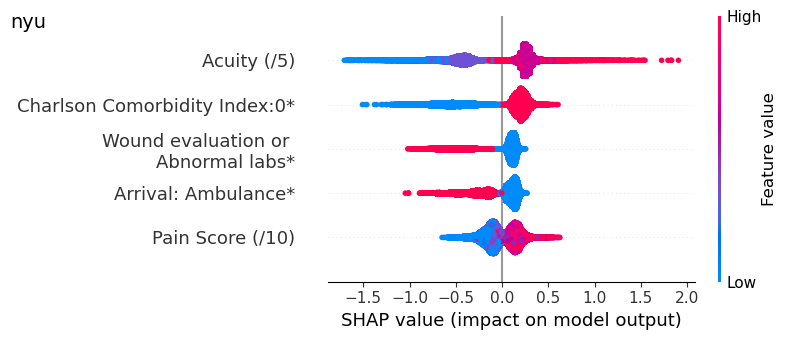

In [63]:
nyu_xgb = xgb_f(X_train_diagxg,  y_train_diagxg,X_test_diagxg, y_test_diagxg, rename_map, 'nyu')

with open('nyu_xgb.pkl', 'wb') as f:
    pickle.dump(nyu_xgb, f)

### Elastic net

In [74]:
nyu_el = elasticnet(X_train_diag, y_train_diag, X_test_diag, y_test_diag, 'nyu')

with open('nyu_el.pkl', 'wb') as f:
    pickle.dump(nyu_el, f)

del nyu_el
gc.collect()

PR AUC: 0.59
AUC: 0.77
              precision    recall  f1-score   support

           0       0.76      0.86      0.81     26945
           1       0.62      0.46      0.53     13277

    accuracy                           0.73     40222
   macro avg       0.69      0.66      0.67     40222
weighted avg       0.72      0.73      0.72     40222



174

### Tabnet

In [78]:
nyu_tabnet = tabnet(X_train_diagtab, y_train_diagtab, X_test_diagtab, y_test_diagtab, 'nyu')

with open('nyu_tabnet.pkl', 'wb') as f:
    pickle.dump(nyu_tabnet, f)

del nyu_tabnet
gc.collect()


Early stopping occurred at epoch 91 with best_epoch = 71 and best_val_auc = 0.78088


/opt/anaconda3/envs/avoid_predict/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


PR AUC: 0.62
AUC: 0.78
              precision    recall  f1-score   support

           0       0.77      0.86      0.81     26945
           1       0.63      0.48      0.55     13277

    accuracy                           0.74     40222
   macro avg       0.70      0.67      0.68     40222
weighted avg       0.72      0.74      0.73     40222



2597

In [79]:
nyu_data = {
    'X_train_diagxg': X_train_diagxg,
    'X_test_diagxg': X_test_diagxg,
    'y_train_diagxg': y_train_diagxg,
    'y_test_diagxg': y_test_diagxg,
    'X_train_diag': X_train_diag,
    'X_test_diag': X_test_diag,
    'y_train_diag': y_train_diag,
    'y_test_diag': y_test_diag,
    'X_train_diagtab': X_train_diagtab,
    'X_test_diagtab': X_test_diagtab,
    'y_train_diagtab': y_train_diagtab,
    'y_test_diagtab': y_test_diagtab
}

with open('nyu_data.pkl', 'wb') as f:
    pickle.dump(nyu_data, f)
    
del X_train_diagxg, X_test_diagxg, y_train_diagxg, y_test_diagxg
del X_train_diag, X_test_diag, y_train_diag, y_test_diag
del X_train_diagtab, X_test_diagtab, y_train_diagtab, y_test_diagtab
gc.collect()

147

## Resources

### Data 

In [66]:
target_columns = ['res']

# XGBoost and Elastic net need different one hot encoding strategies
X_train_resxg, X_test_resxg, y_train_resxg, y_test_resxg = data_process(
    data_impute,
    predictors, 
    target_columns, 
    drop_first_in=False,
    tab = 'not_tab'
)

X_train_res, X_test_res, y_train_res, y_test_res = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=True,
    tab = 'not_tab'
)

X_train_restab, X_test_restab, y_train_restab, y_test_restab = data_process(
    data_impute, 
    predictors, 
    target_columns, 
    drop_first_in=False,
    tab = 'tab'
)

Train X shape: (160884, 76)
Test X shape: (40222, 76)

Check proportions of outcome in data:
--- res ---
y_train proportions:
res
0    0.760417
1    0.239583
Name: proportion, dtype: float64
y_test proportions:
res
0    0.76043
1    0.23957
Name: proportion, dtype: float64
Train X shape: (160884, 68)
Test X shape: (40222, 68)

Check proportions of outcome in data:
--- res ---
y_train proportions:
res
0    0.760417
1    0.239583
Name: proportion, dtype: float64
y_test proportions:
res
0    0.76043
1    0.23957
Name: proportion, dtype: float64
Train X shape: (160884, 18)
Test X shape: (40222, 18)

Check proportions of outcome in data:
--- res ---
y_train proportions:
res
0    0.760417
1    0.239583
Name: proportion, dtype: float64
y_test proportions:
res
0    0.76043
1    0.23957
Name: proportion, dtype: float64


### XGBoost

PR AUC: 0.56
AUC: 0.80
              precision    recall  f1-score   support

           0       0.90      0.69      0.78     30586
           1       0.43      0.75      0.55      9636

    accuracy                           0.71     40222
   macro avg       0.66      0.72      0.66     40222
weighted avg       0.79      0.71      0.73     40222



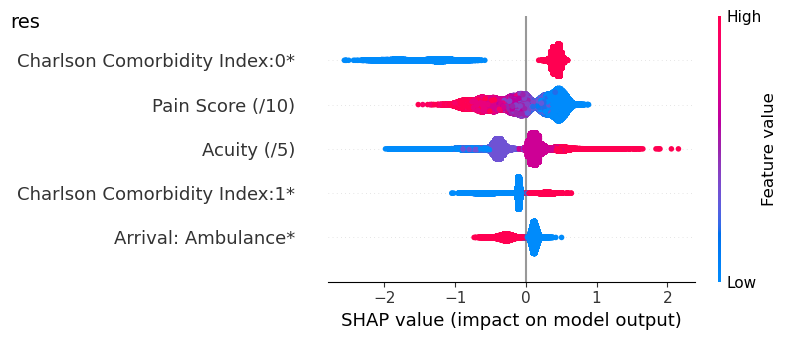

In [67]:
res_xgb = xgb_f(X_train_resxg, y_train_resxg, X_test_resxg, y_test_resxg, rename_map, 'res')

with open('res_xg.pkl', 'wb') as f:
    pickle.dump(res_xgb, f)

### Elastic net

In [75]:
res_el = elasticnet(X_train_res, y_train_res, X_test_res, y_test_res, 'res')

with open('res_el.pkl', 'wb') as f:
    pickle.dump(res_el, f)

del res_el
gc.collect()

PR AUC: 0.53
AUC: 0.79
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     30586
           1       0.62      0.26      0.36      9636

    accuracy                           0.78     40222
   macro avg       0.71      0.60      0.62     40222
weighted avg       0.76      0.78      0.75     40222



174

### Tabnet

In [80]:
res_tabnet = tabnet(X_train_res, y_train_res, X_test_res, y_test_res, 'res')

with open('res_tabnet.pkl', 'wb') as f:
    pickle.dump(res_tabnet, f)

del res_tabnet
gc.collect()


Early stopping occurred at epoch 69 with best_epoch = 49 and best_val_auc = 0.79684


/opt/anaconda3/envs/avoid_predict/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


PR AUC: 0.55
AUC: 0.80
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     30586
           1       0.63      0.29      0.40      9636

    accuracy                           0.79     40222
   macro avg       0.72      0.62      0.63     40222
weighted avg       0.76      0.79      0.76     40222



2671

In [81]:
res_data = {
    'X_train_resxg': X_train_resxg,
    'X_test_resxg': X_test_resxg,
    'y_train_resxg': y_train_resxg,
    'y_test_resxg': y_test_resxg,
    'X_train_res': X_train_res,
    'X_test_res': X_test_res,
    'y_train_res': y_train_res,
    'y_test_res': y_test_res,
    'X_train_restab': X_train_restab,
    'X_test_restab': X_test_restab,
    'y_train_restab': y_train_restab,
    'y_test_restab': y_test_restab
}

with open('res_data.pkl', 'wb') as f:
    pickle.dump(res_data, f)
    
del X_train_resxg, X_test_resxg, y_train_resxg, y_test_resxg
del X_train_res, X_test_res, y_train_res, y_test_res
del X_train_restab, X_test_restab, y_train_restab, y_test_restab
gc.collect()

147